IMPORTING MODULES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
import cv2
from skimage import io
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #libs to upload to colab
%matplotlib inline

MOUNTING OUR DRIVE

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/brain_cancer/kaggle_3m

/content/drive/MyDrive/brain_cancer/kaggle_3m


**Understanding the Data Features**

In [4]:
brain_df = pd.read_csv('data_mask.csv')
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [5]:
brain_df.head(5)

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [6]:
#path to the rain MRI image
brain_df.mask_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [7]:
#path to the segmentation mask
brain_df.image_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [8]:
#Obtain The Number Of Images with Mask
brain_df['mask'].value_counts()
#Pretty Imbalanced

mask
0    2556
1    1373
Name: count, dtype: int64

**Perform Data Visualization**

In [9]:
brain_df

patient_id  \
0     TCGA_CS_5395_19981004   
1     TCGA_CS_5395_19981004   
2     TCGA_CS_5395_19981004   
3     TCGA_CS_5395_19981004   
4     TCGA_CS_5395_19981004   
...                     ...   
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 4 columns]

In [10]:
brain_df['mask'].value_counts().index

Index([0, 1], dtype='int64', name='mask')

In [11]:
#Use plotly to plot interactive Bar Charts
import plotly.graph_objects as go # Changed alias to go for convention
fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df ['mask'].value_counts())]) # Corrected the function call and alias
fig.update_traces(marker_color = 'rgb(158,202,225)', marker_line_color = 'rgb(8,48,107)',
                  marker_line_width = 1.5, opacity = 0.6)
fig.show()

In [12]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [13]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

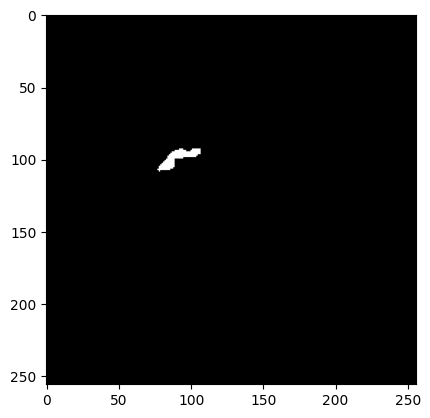

In [14]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

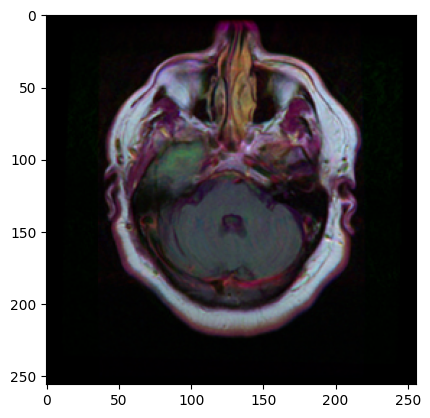

In [15]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

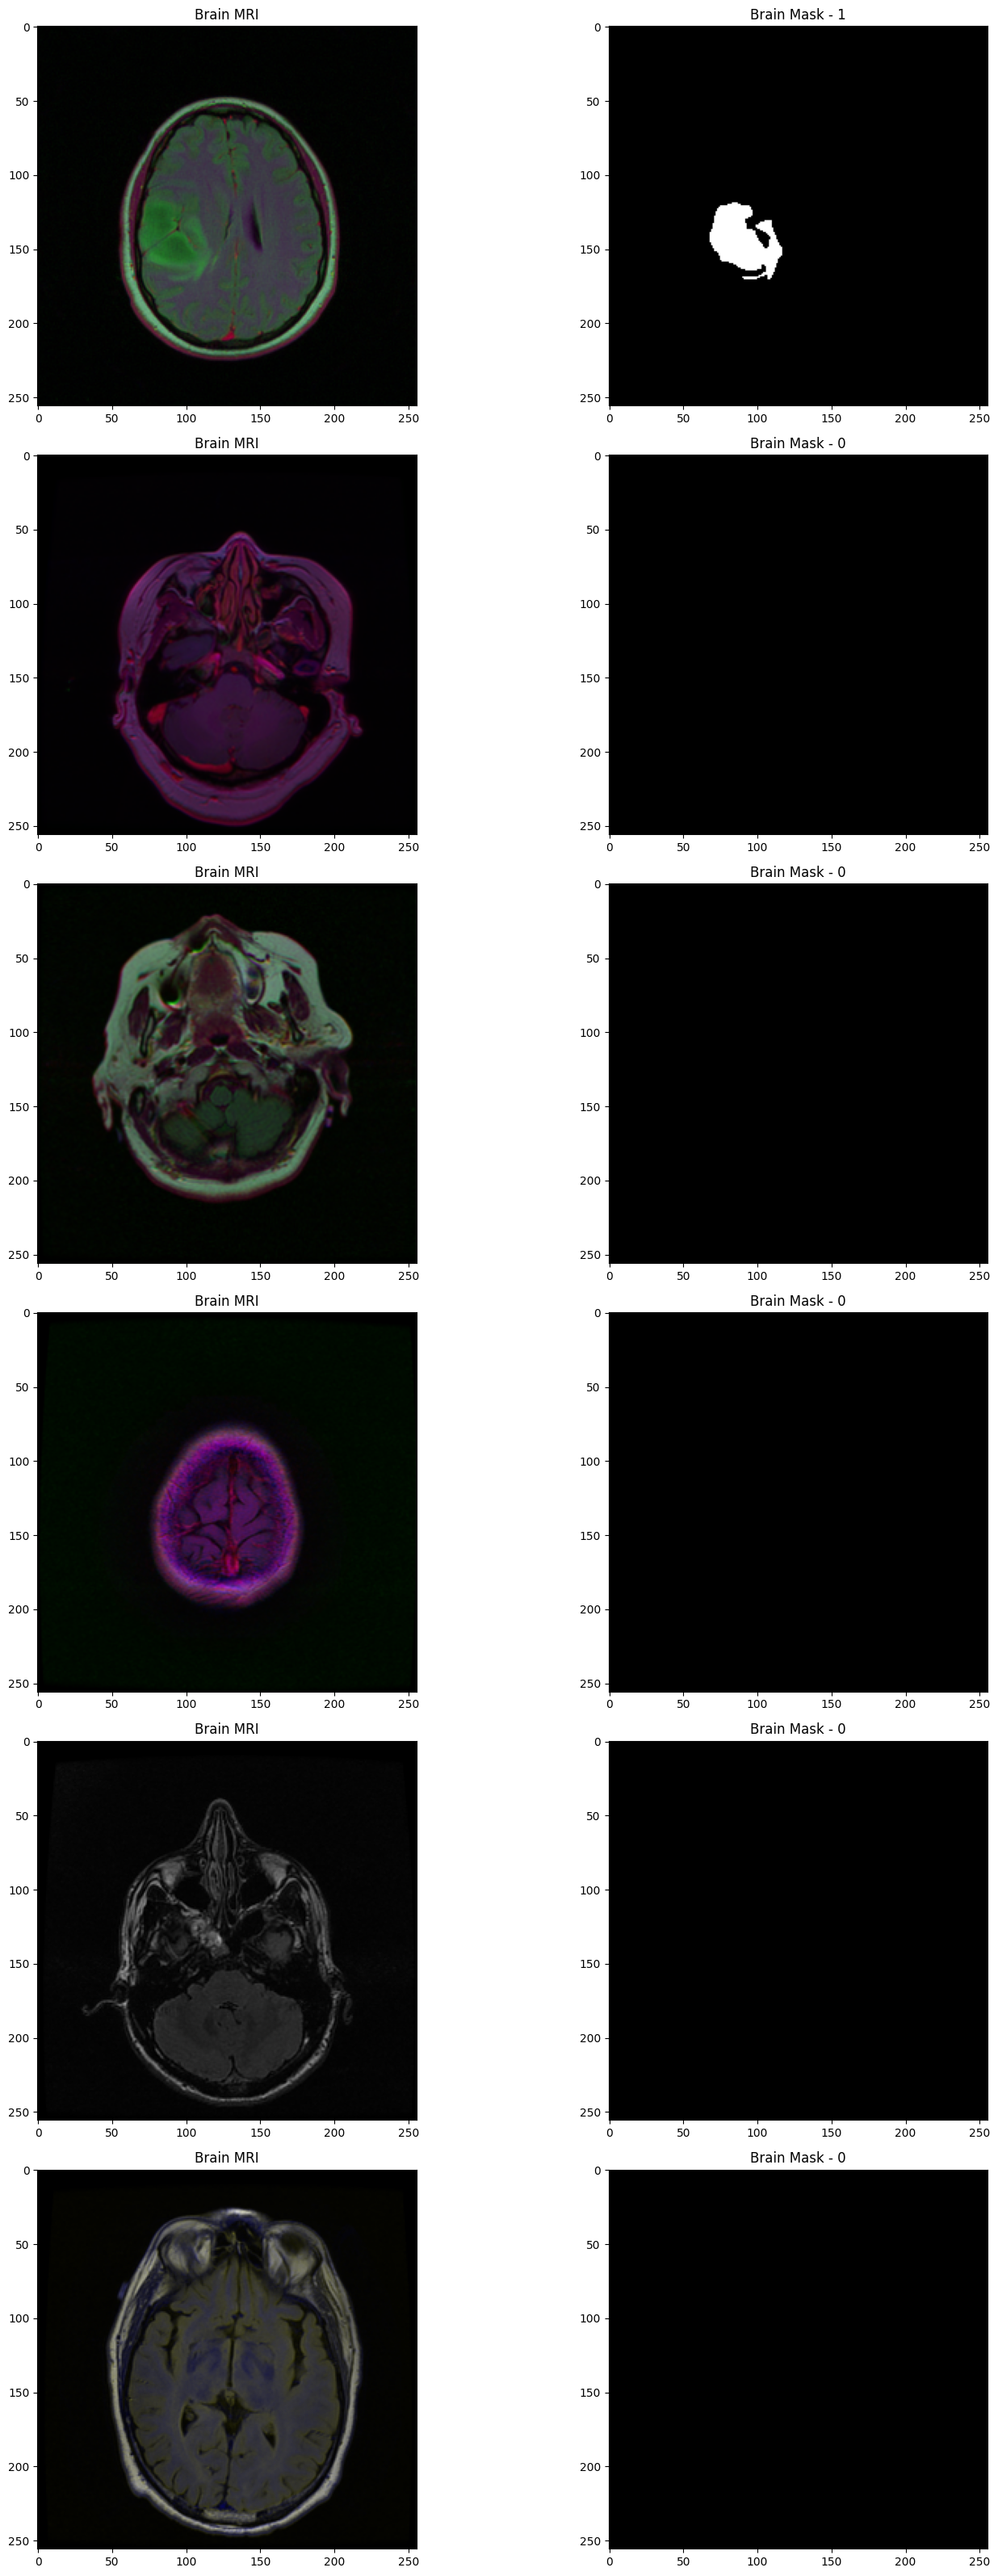

In [16]:
#Basic Visualisations : Visualise The Images (MRI and Mask) in the dataset seperately
fig, axs = plt.subplots(6, 2, figsize = (16, 32))
count = 0
for i in range(6):
  i = random.randint(0, len(brain_df))#select random index
  axs[count][0].title.set_text('Brain MRI')
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i]))
  axs[count][1].title.set_text('Brain Mask - ' + str(brain_df['mask'][i]))
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))
  count += 1
fig.tight_layout()

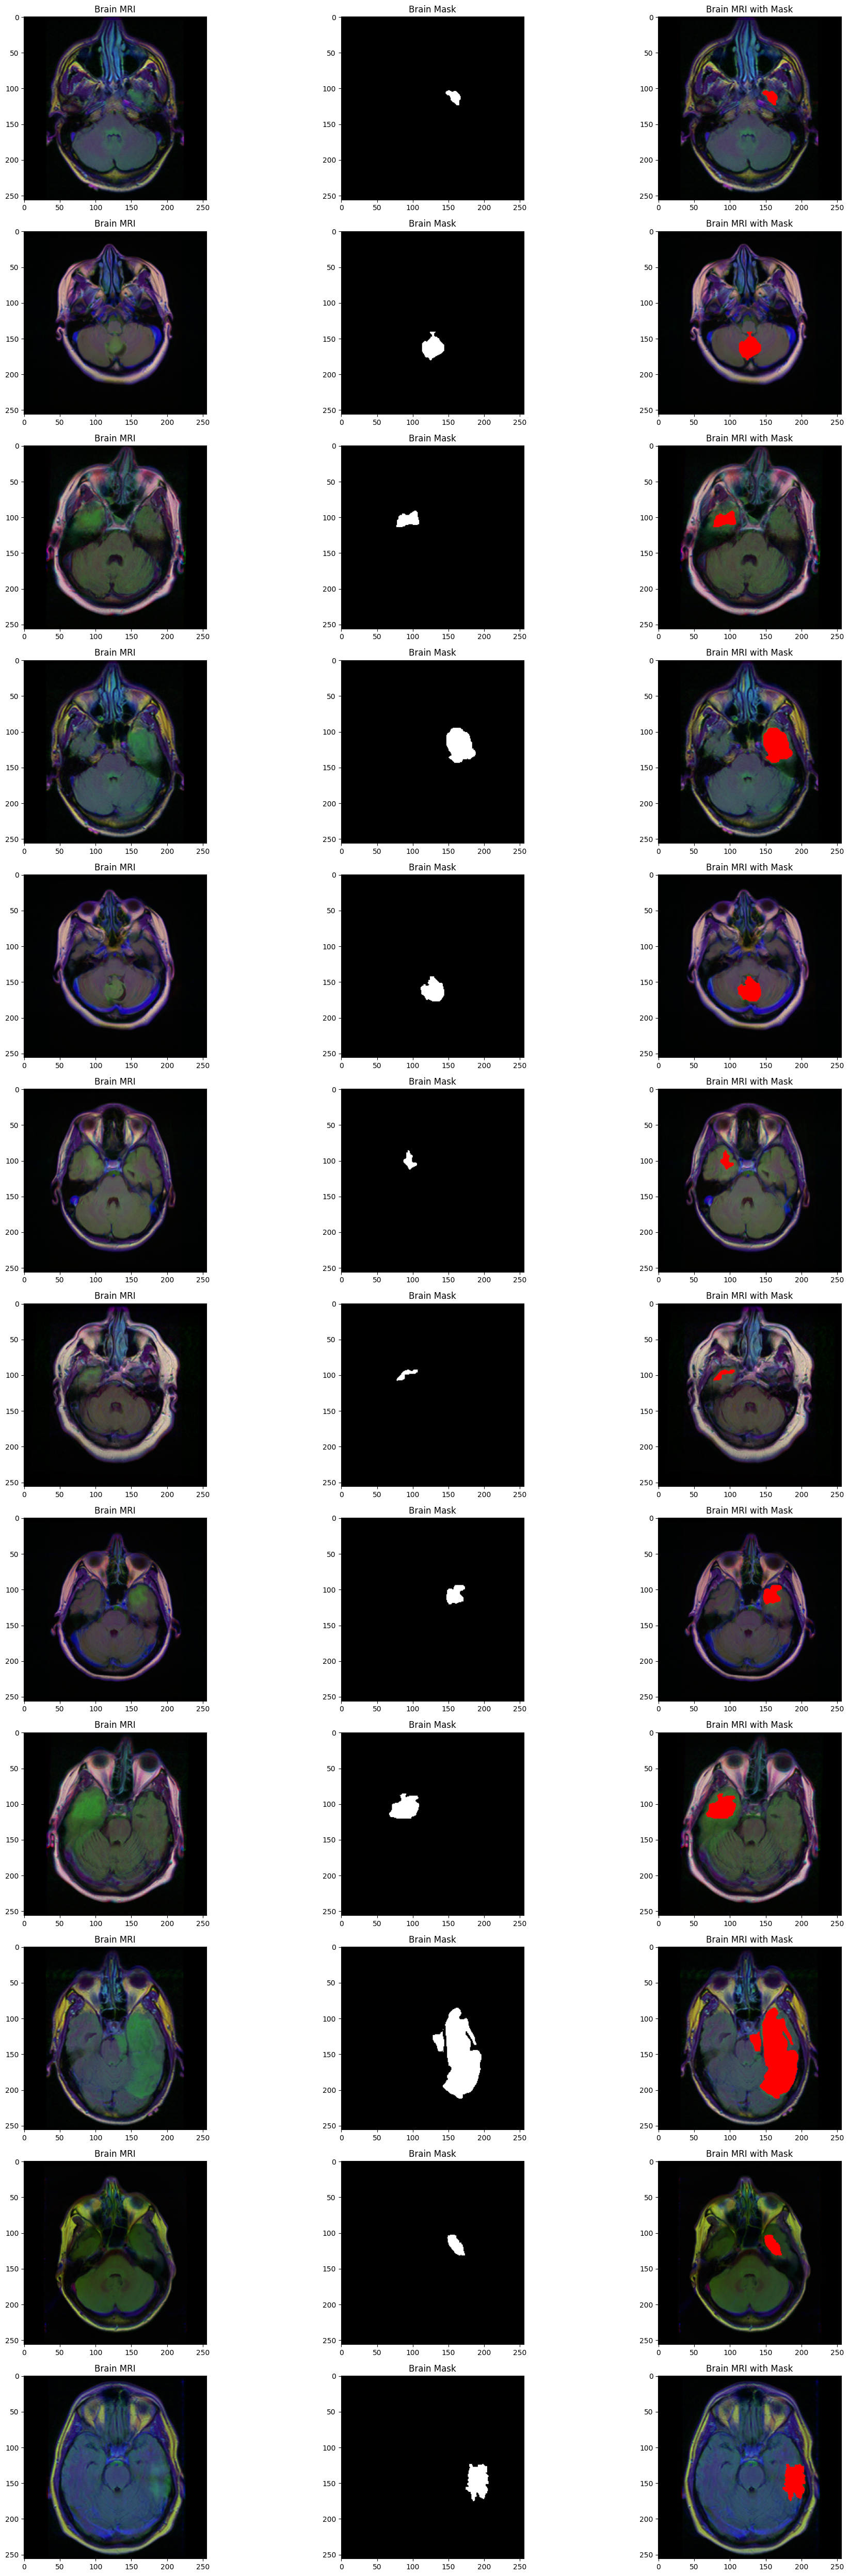

In [17]:
count = 0
fig, axs = plt.subplots(12, 3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("Brain Mask")
    axs[count][1].imshow(mask, cmap = "gray")

    #replace the values in the image with red color(255,0,0) if any mask pixel in the mask was = 255
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text("Brain MRI with Mask")
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()

In [18]:
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [19]:
brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 92.2+ KB


In [20]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [21]:
pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00


In [22]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.15)

In [23]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.15)

train['mask'] = train['mask'].astype(str)
test['mask'] = test['mask'].astype(str)

train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    subset = 'training',
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256,256))


valid_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    subset = 'validation',
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256,256))

test_generator = datagen.flow_from_dataframe(
    dataframe = test,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    batch_size = 16,
    shuffle = False,
    class_mode = 'categorical',
    target_size = (256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [24]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor= Input(shape = (256, 256, 3)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [25]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [26]:
for layer in basemodel.layers:
  layers.trainable = False

In [27]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [28]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 25,751,426 (98.23 MB)

 Trainable params: 25,698,306 (98.03 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [29]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [30]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath = 'classifier-resnet-weights.keras', verbose = 1, save_best_only = True)

In [31]:
history = model.fit(train_generator, steps_per_epoch=train_generator.n // 16, epochs =1, validation_data=valid_generator, validation_steps=valid_generator.n // 16, callbacks = [checkpointer, earlystopping])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6415 - loss: 1.1934
Epoch 1: val_loss improved from inf to 1.21875, saving model to classifier-resnet-weights.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 1909s 10s/step - accuracy: 0.6418 - loss: 1.1915 - val_accuracy: 0.6653 - val_loss: 1.2188


In [32]:
model_json = model.to_json()
with open ("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

In [33]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= "flatten")(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [34]:
with open('classifier-resnet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('classifier-resnet-weights.keras')
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [35]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 319s 9s/step


In [36]:
test_predict.shape

test_predict

array([[0.97222733, 0.02777266],
       [0.97216606, 0.02783389],
       [0.9719562 , 0.02804381],
       ...,
       [0.9720361 , 0.02796385],
       [0.97193897, 0.02806105],
       [0.9720952 , 0.02790476]], dtype=float32)

In [37]:
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)


In [38]:
predict

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

In [39]:
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [40]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.6458333333333334

<Axes: >

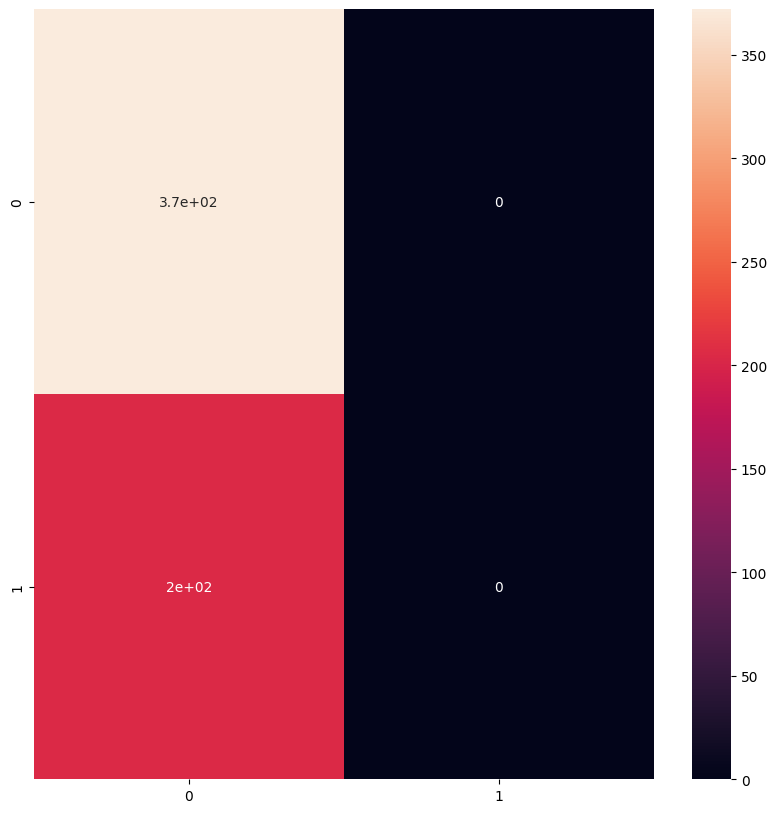

In [41]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True)

In [42]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.65      1.00      0.78       372
           1       0.00      0.00      0.00       204

   micro avg       0.65      0.65      0.65       576
   macro avg       0.32      0.50      0.39       576
weighted avg       0.42      0.65      0.51       576



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [43]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape


(1373, 4)

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [45]:
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask = list(X_val.mask_path)

In [46]:
import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, ids, masks, batch_size=16, img_size=256, num_channels=3):
        self.ids = ids
        self.masks = masks
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_channels = num_channels
        self.on_epoch_end()
        print(f"DataGenerator initialized for {len(self.ids)} samples. Batch size: {self.batch_size}")
        if not self.ids:
            print("Warning: DataGenerator initialized with empty 'ids'.")
        if not self.masks:
            print("Warning: DataGenerator initialized with empty 'masks'.")


    def __len__(self):
        # Denotes the number of batches per epoch
        num_batches = int(np.floor(len(self.ids) / self.batch_size))
        # Ensure at least one batch if there is data, to allow Keras to trace the model
        if num_batches == 0 and len(self.ids) > 0:
            num_batches = 1
        print(f"DataGenerator __len__ returning: {num_batches} batches")
        return num_batches


    def __getitem__(self, index):
        # Generate indexes of the batch
        # Ensure that the index is within the valid range, preventing errors if __len__ was adjusted
        if index >= self.__len__():
            raise IndexError("DataGenerator index out of range")

        current_batch_ids = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        list_ids = [self.ids[k] for k in current_batch_ids]
        list_masks = [self.masks[k] for k in current_batch_ids]

        # Generate data
        X, y = self.__data_generation(list_ids, list_masks)
        return X, y

    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.ids))
        np.random.shuffle(self.indexes) # Shuffle to ensure different order each epoch

    def __data_generation(self, list_ids, list_masks):
        # Initialize arrays with zeros to handle skipped samples and ensure consistent shapes/types
        X = np.zeros((len(list_ids), self.img_size, self.img_size, self.num_channels), dtype=np.float32)
        y = np.zeros((len(list_ids), self.img_size, self.img_size, 1), dtype=np.float32)

        for i, (image_id, mask_id) in enumerate(zip(list_ids, list_masks)):
            try:
                # Read image
                img = cv2.imread(image_id)
                if img is None:
                    print(f"Warning: Image not found or could not be read: {image_id}. Filling with zeros.")
                    continue # Skip to next sample, current X[i] is already zeros
                img = cv2.resize(img, (self.img_size, self.img_size))
                X[i,] = img / 255.0

                # Read mask
                mask = cv2.imread(mask_id, cv2.IMREAD_GRAYSCALE)
                if mask is None:
                    print(f"Warning: Mask not found or could not be read: {mask_id}. Filling with zeros.")
                    continue # Skip to next sample, current y[i] is already zeros
                mask = cv2.resize(mask, (self.img_size, self.img_size))
                mask = np.expand_dims(mask, axis=-1) # Add channel dimension
                y[i,] = mask / 255.0

            except Exception as e:
                print(f"Error processing image {image_id} or mask {mask_id}: {e}. Filling with zeros.")
                # The corresponding X[i] and y[i] will remain zeros due to initialization

        return X, y

# Instantiate the generators
train_generator = DataGenerator(train_ids, train_mask)
validation_generator = DataGenerator(val_ids, val_mask)

DataGenerator initialized for 1167 samples. Batch size: 16
DataGenerator initialized for 103 samples. Batch size: 16


In [47]:
def resblock(X, f):


  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [48]:
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [49]:


input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [50]:
model_seg.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      2,112 │ max_pooling2d_1[

 Total params: 1,210,513 (4.62 MB)

 Trainable params: 1,206,129 (4.60 MB)

 Non-trainable params: 4,384 (17.12 KB)

In [51]:
from tensorflow.keras import backend as K

def tversky_loss(y_true, y_pred, alpha=0.7):
    # Flatten the arrays to work with 1D vectors
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    # Calculate true positives (tp), false positives (fp) and false negatives (fn)
    tp = K.sum(y_true_f * y_pred_f)
    fp = K.sum((1 - y_true_f) * y_pred_f)
    fn = K.sum(y_true_f * (1 - y_pred_f))

    # Calculate Tversky index
    tversky = tp / (tp + alpha * fp + (1 - alpha) * fn)
    return 1 - tversky

def focal_tversky_loss(y_true, y_pred, alpha=0.7, gamma=0.75):
    # Calculate Tversky loss
    tversky_l = tversky_loss(y_true, y_pred, alpha)
    # Calculate Focal Tversky loss
    return K.pow(tversky_l, gamma)

def tversky(y_true, y_pred, alpha=0.7):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    # Compute the denominator terms for false positives and false negatives
    fp = K.sum((1 - y_true_f) * y_pred_f)  # False Positives
    fn = K.sum(y_true_f * (1 - y_pred_f))  # False Negatives

    # Compute Tversky index
    return (intersection + K.epsilon()) / (intersection + alpha * fp + (1 - alpha) * fn + K.epsilon())

focal_tversky = focal_tversky_loss

In [52]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate= 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [53]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.keras", verbose=1, save_best_only=True)

In [54]:
history = model_seg.fit(train_generator, epochs = 1, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



DataGenerator __len__ returning: 72 batches
DataGenerator __len__ returning: 72 batches
DataGenerator __len__ returning: 72 batches
DataGenerator __len__ returning: 72 batches
DataGenerator __len__ returning: 72 batches
DataGenerator __len__ returning: 72 batches
DataGenerator __len__ returning: 72 batches
DataGenerator __len__ returning: 72 batches
DataGenerator __len__ returning: 72 batches
 1/72 ━━━━━━━━━━━━━━━━━━━━ 51:55 44s/step - loss: 0.9743 - tversky: 0.0341DataGenerator __len__ returning: 72 batches
 2/72 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 0.9743 - tversky: 0.0342DataGenerator __len__ returning: 72 batches
 3/72 ━━━━━━━━━━━━━━━━━━━━ 5:35 5s/step - loss: 0.9745 - tversky: 0.0339  DataGenerator __len__ returning: 72 batches
 4/72 ━━━━━━━━━━━━━━━━━━━━ 6:37 6s/step - loss: 0.9751 - tversky: 0.0331DataGenerator __len__ returning: 72 batches
 5/72 ━━━━━━━━━━━━━━━━━━━━ 7:23 7s/step - loss: 0.9750 - tversky: 0.0332DataGenerator __len__ returning: 72 batches
 6/72 ━━━━━━━━━━━━

In [55]:
model_json = model_seg.to_json()
with open ("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

In [56]:
from tensorflow.keras import backend as K

def tversky_loss(y_true, y_pred, alpha=0.7):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    tp = K.sum(y_true_f * y_pred_f)
    fp = K.sum((1 - y_true_f) * y_pred_f)
    fn = K.sum(y_true_f * (1 - y_pred_f))
    tversky = tp / (tp + alpha * fp + (1 - alpha) * fn)
    return 1 - tversky

def focal_tversky_loss(y_true, y_pred, alpha=0.7, gamma=0.75):
    tversky_l = tversky_loss(y_true, y_pred, alpha)
    return K.pow(tversky_l, gamma)

def tversky(y_true, y_pred, alpha=0.7):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    fp = K.sum((1 - y_true_f) * y_pred_f)
    fn = K.sum(y_true_f * (1 - y_pred_f))
    return (intersection + K.epsilon()) / (intersection + alpha * fp + (1 - alpha) * fn + K.epsilon())

with open('ResUNet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture
model_seg = tf.keras.models.model_from_json(json_savedModel, custom_objects={'focal_tversky_loss': focal_tversky_loss, 'tversky': tversky, 'Model': tf.keras.Model})
model_seg.load_weights('ResUNet-weights.keras')
adam = tf.keras.optimizers.Adam(learning_rate= 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky_loss, metrics = [tversky])

In [57]:
from utilities import prediction

image_id, mask, has_mask = prediction(test, model, model_seg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━

In [59]:
df_pred = pd.DataFrame({'image_path' : image_id, 'predicted_mask' : mask, 'has_mask' : has_mask})
df_pred

image_path predicted_mask  \
0    TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_19...        No mask   
1    TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_19...        No mask   
2    TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_30...        No mask   
3    TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_10...        No mask   
4    TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_10...        No mask   
..                                                 ...            ...   
585  TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_14...        No mask   
586  TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_5.tif        No mask   
587  TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_1.tif        No mask   
588  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_16...        No mask   
589  TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_27...        No mask   

     has_mask  
0           0  
1           0  
2           0  
3           0  
4           0  
..        ...  
585         0  
586         0  
587         0  
588         0  
589         0  

[590 rows x 3 columns]

In [60]:
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_19...   
1  TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_19...   
2  TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_30...   
3  TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_10...   
4  TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_10...   

                                           mask_path mask predicted_mask  \
0  TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_19...    1        No mask   
1  TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_19...    0        No mask   
2  TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_30...    0        No mask   
3  TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_10...    0        No mask   
4  TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_10...    0        No mask   

   has_mask  
0         0  
1         0  
2         0  
3         0  
4         0

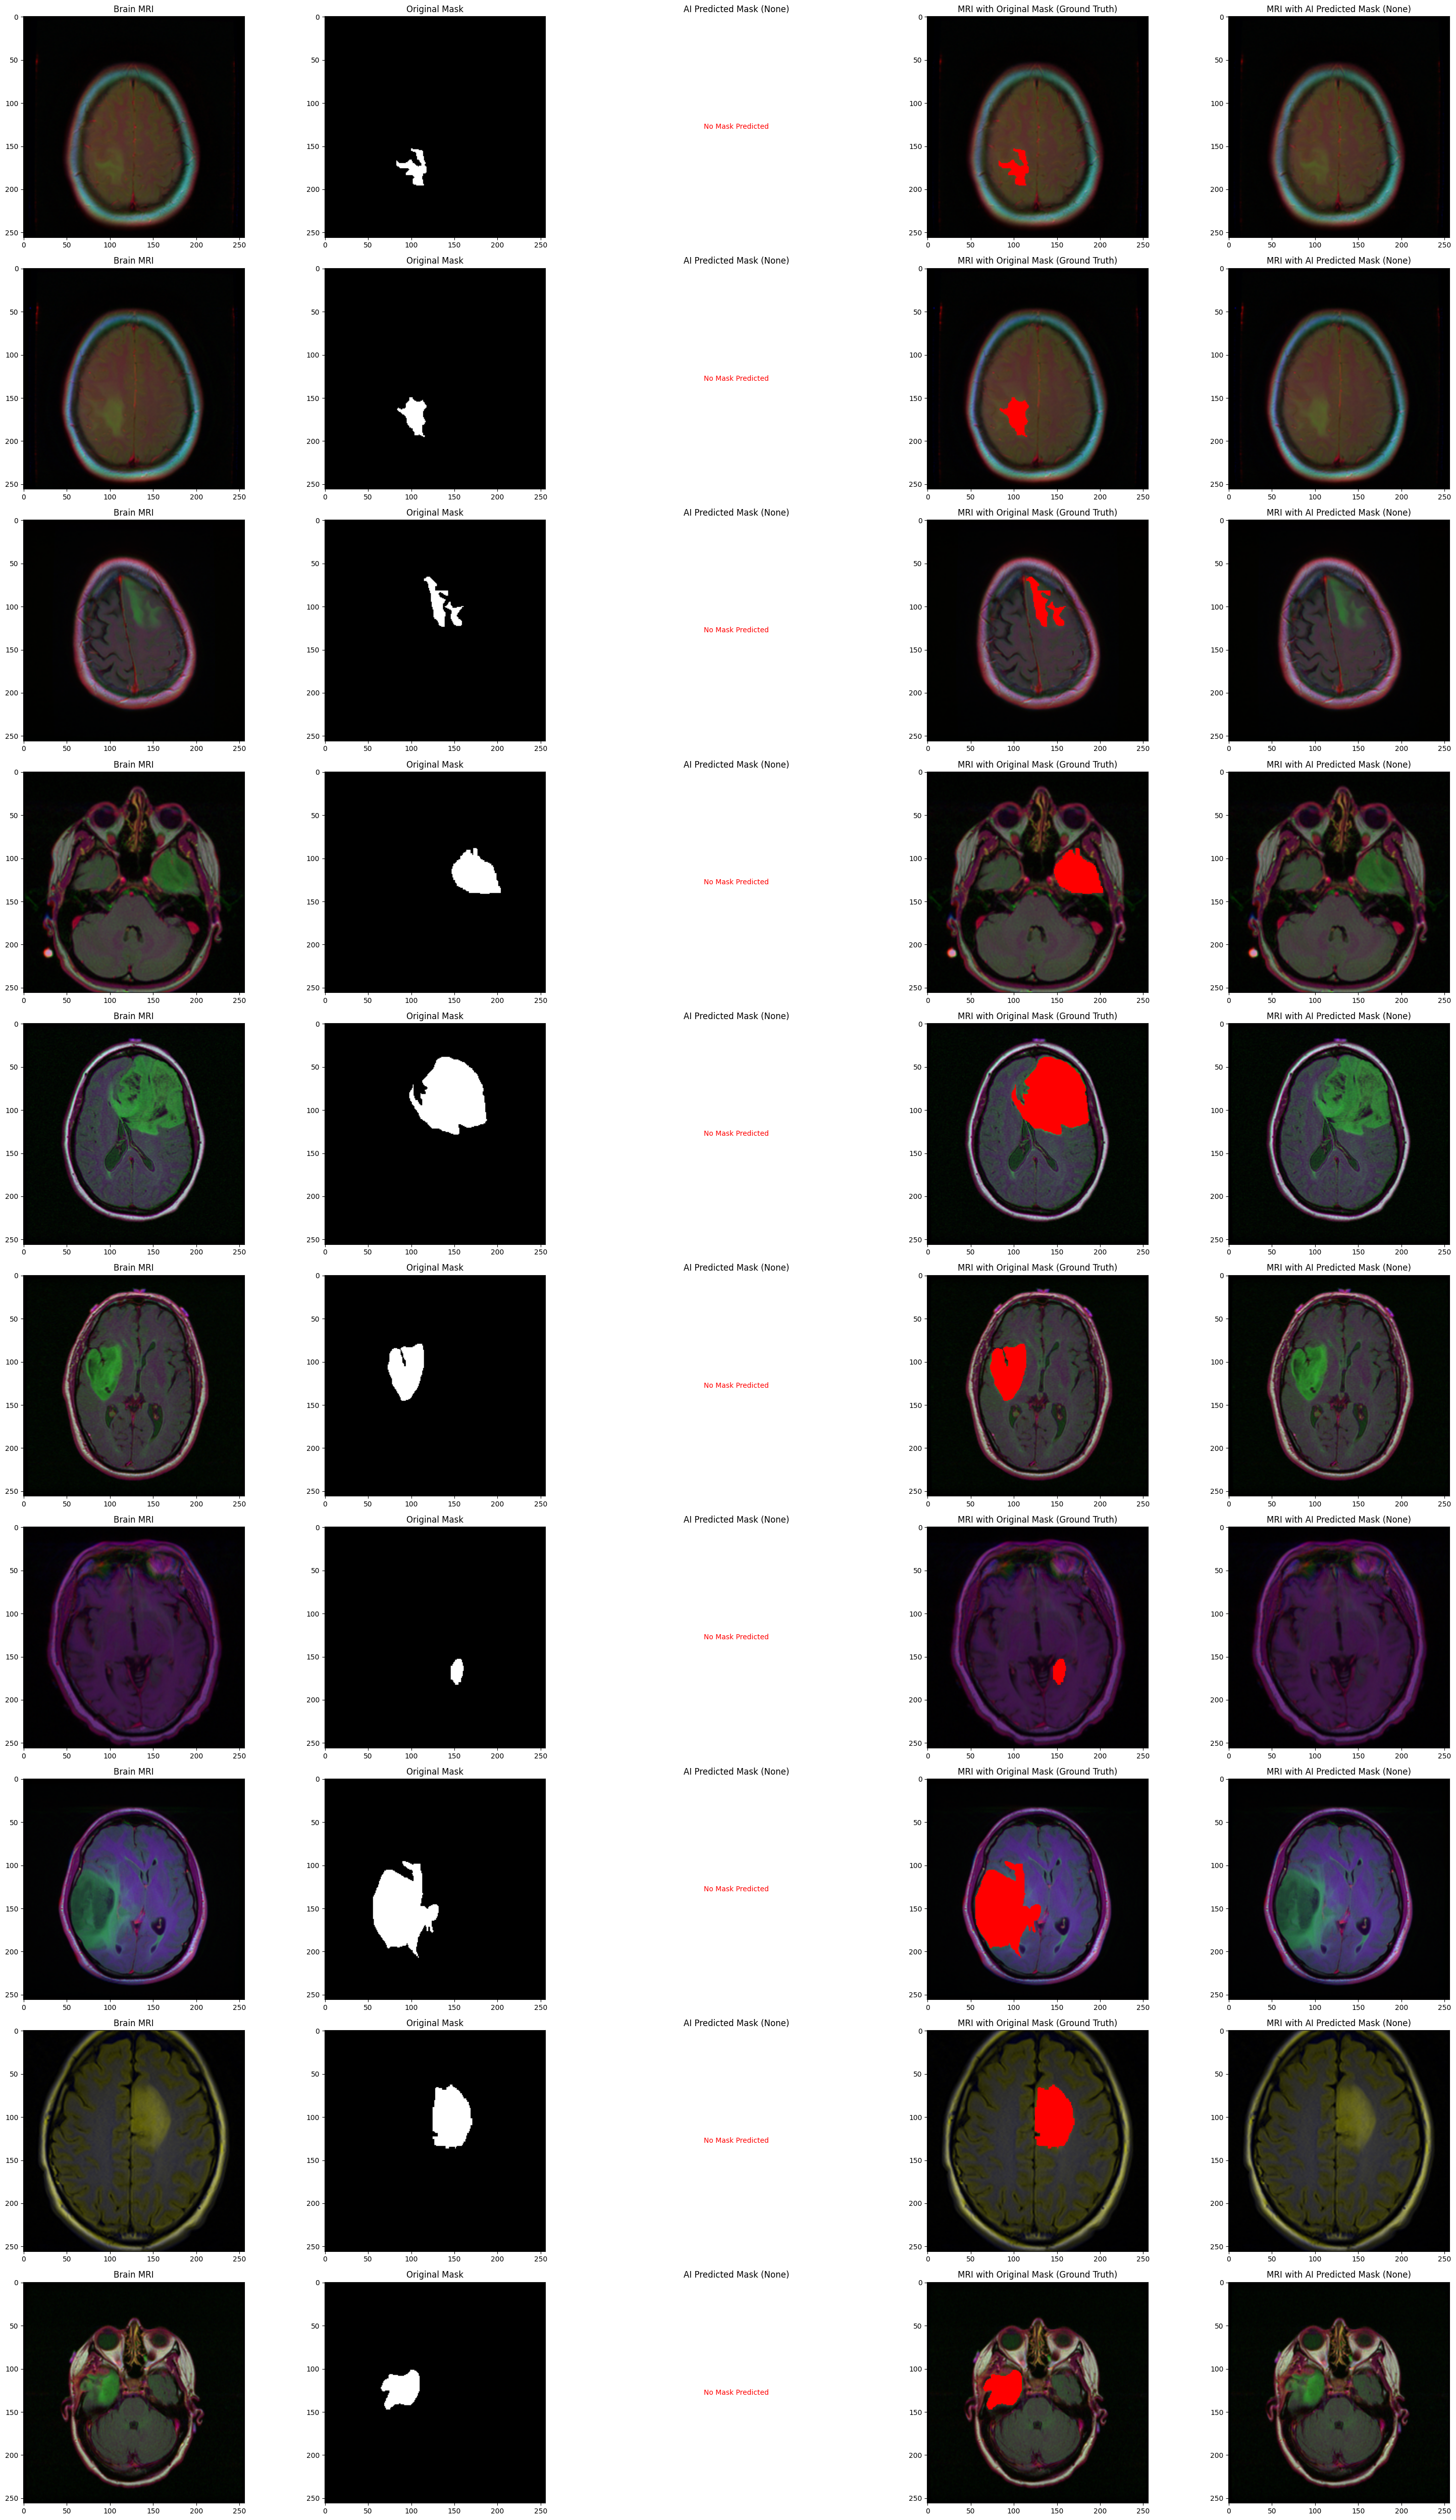

In [67]:
count = 0
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  # Change condition to plot based on ground truth mask existence
  # We want to see how the model performs on images that actually have a tumor
  if df_pred['mask'][i] == '1' and count < 10: # Assuming 'mask' column is string '0' or '1'
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image (ground truth)
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask, cmap='gray') # Use cmap='gray' for binary masks

    # Obtain the predicted mask for the image
    predicted_mask_data = df_pred.predicted_mask[i]

    if isinstance(predicted_mask_data, str) and predicted_mask_data == 'No mask':
        axs[count][2].title.set_text("AI Predicted Mask (None)")
        axs[count][2].text(0.5, 0.5, "No Mask Predicted", horizontalalignment='center', verticalalignment='center', transform=axs[count][2].transAxes, fontsize=10, color='red')
        axs[count][2].axis('off') # Turn off axes for a cleaner look

        # For MRI with AI Predicted Mask, show original image if no mask predicted
        img_predicted_overlay = img.copy() # Use a copy to avoid modifying original img
        axs[count][4].title.set_text("MRI with AI Predicted Mask (None)")
        axs[count][4].imshow(img_predicted_overlay)
    else:
        # Assuming predicted_mask_data is a NumPy array, possibly with an extra dimension
        # The original code had [0] before squeeze, let's keep it if that's how `prediction` returns it.
        predicted_mask = np.asarray(predicted_mask_data)[0].squeeze().round()
        axs[count][2].title.set_text("AI Predicted Mask")
        axs[count][2].imshow(predicted_mask, cmap='gray') # Use cmap='gray' for binary masks

        img_predicted_overlay = img.copy() # Use a copy
        # Only apply overlay if the predicted mask has positive values
        if predicted_mask.max() > 0:
            img_predicted_overlay[predicted_mask == 1] = (0, 255, 0)
        axs[count][4].title.set_text("MRI with AI Predicted Mask")
        axs[count][4].imshow(img_predicted_overlay)

    # Apply the original mask to the image 'mask==255' (Ground Truth)
    img_original_overlay = img.copy() # Use a copy
    img_original_overlay[mask == 255] = (255, 0, 0) # Red color for original mask
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img_original_overlay)

    count += 1
fig.tight_layout()
plt.show()